While waiting for Star Wars: The Force Awakens to come out, the team at FiveThirtyEight became interested in answering some questions about Star Wars fans. In particular, they wondered: does the rest of America realize that “The Empire Strikes Back” is clearly the best of the bunch?

The team needed to collect data addressing this question. To do this, they surveyed Star Wars fans using the online tool SurveyMonkey. They received 835 total responses, which you download from their GitHub repository.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from mpl_toolkits.basemap import Basemap
%matplotlib inline


star_wars = pd.read_csv("star_wars.csv", encoding="ISO-8859-1")
star_wars.head()

,RespondentID,Have you seen any of the 6 films in the Star Wars franchise?,Do you consider yourself to be a fan of the Star Wars film franchise?,Which of the following Star Wars films have you seen? Please select all that apply.,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.,...,Unnamed: 28,Which character shot first?,Are you familiar with the Expanded Universe?,Do you consider yourself to be a fan of the Expanded Universe?ï¿½ï¿½,Do you consider yourself to be a fan of the Star Trek franchise?,Gender,Age,Household Income,Education,Location (Census Region)
0,NaN,Response,Response,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,Star Wars: Episode I The Phantom Menace,...,Yoda,Response,Response,Response,Response,Response,Response,Response,Response,Response
1,3.292880e+09,Yes,Yes,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,3,...,Very favorably,I don't understand this question,Yes,No,No,Male,18-29,NaN,High school degree,South Atlantic
2,3.292880e+09,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,Male,18-29,"$0 - $24,999",Bachelor degree,West South Central
3,3.292765e+09,Yes,No,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,NaN,NaN,NaN,1,...,Unfamiliar (N/A),I don't understand this question,No,NaN,No,Male,18-29,"$0 - $24,999",High school degree,West North Central
4,3.292763e+09,Yes,Yes,Star Wars: Episode I The Phantom Menace,Star Wars: Episode II Attack of the Clones,Star Wars: Episode III Revenge of the Sith,Star Wars: Episode IV A New Hope,Star Wars: Episode V The Empire Strikes Back,Star Wars: Episode VI Return of the Jedi,5,...,Very favorably,I don't understand this question,No,NaN,Yes,Male,18-29,"$100,000 - $149,999",Some college or Associate degree,West North Central


Let's remove any rows where RespondentID is NaN

In [59]:
star_wars = star_wars[star_wars['RespondentID'].notnull()]

The data has several columns, including:

`RespondentID` - An anonymized ID for the respondent (person taking the survey)
`Gender` - The respondent's gender
`Age` - The respondent's age
`Household Income` - The respondent's income
`Education` - The respondent's education level
`Location (Census Region)` - The respondent's location
`Have you seen any of the 6 films in the Star Wars franchise?` - Has a Yes or No response
`Do you consider yourself to be a fan of the Star Wars film franchise?` - Has a Yes or No response

There are several other columns containing answers to questions about the Star Wars movies. For some questions, the respondent had to check one or more boxes. This type of data is difficult to represent in columnar format. As a result, this data set needs a lot of cleaning.

First, you'll need to remove the invalid rows. For example, RespondentID is supposed to be a unique ID for each respondent, but it's blank in some rows. You'll need to remove any rows with an invalid RespondentID

Take a look at the next two columns, which are:

`Have you seen any of the 6 films in the Star Wars franchise?`
`Do you consider yourself to be a fan of the Star Wars film franchise?`

Both represent Yes/No questions. They can also be NaN where a respondent chooses not to answer a question. We can use the pandas.Series.value_counts() method on a series to see all of the unique values in a column, along with the total number of times each value appears.

In [60]:
star_wars['Have you seen any of the 6 films in the Star Wars franchise?'].value_counts()

Yes    936
No     250
Name: Have you seen any of the 6 films in the Star Wars franchise?, dtype: int64

In [61]:
star_wars['Do you consider yourself to be a fan of the Star Wars film franchise?'].value_counts()

Yes    552
No     284
Name: Do you consider yourself to be a fan of the Star Wars film franchise?, dtype: int64

Both columns are currently string types, because the main values they contain are Yes and No. We can make the data a bit easier to analyze down the road by converting each column to a Boolean having only the values True, False, and NaN. Booleans are easier to work with because we can select the rows that are True or False without having to do a string comparison

In [62]:
yes_no = {
    "Yes": True,
    "No": False
}

star_wars['Have you seen any of the 6 films in the Star Wars franchise?'] = star_wars['Have you seen any of the 6 films in the Star Wars franchise?'].map(yes_no)
star_wars['Do you consider yourself to be a fan of the Star Wars film franchise?'] = star_wars['Do you consider yourself to be a fan of the Star Wars film franchise?'].map(yes_no)

In [63]:
star_wars['Have you seen any of the 6 films in the Star Wars franchise?'].value_counts()

True     936
False    250
Name: Have you seen any of the 6 films in the Star Wars franchise?, dtype: int64

The next six columns represent a single checkbox question. The respondent checked off a series of boxes in response to the question, Which of the following Star Wars films have you seen? Please select all that apply.

The columns for this question are:


`Which of the following Star Wars films have you seen? Please select all that apply.` - Whether or not the respondent saw Star Wars: Episode I The Phantom Menace.
`Unnamed: 4` - Whether or not the respondent saw Star Wars: Episode II Attack of the Clones.
`Unnamed: 5` - Whether or not the respondent saw Star Wars: Episode III Revenge of the Sith.
`Unnamed: 6` - Whether or not the respondent saw Star Wars: Episode IV A New Hope.
`Unnamed: 7` - Whether or not the respondent saw Star Wars: Episode V The Empire Strikes Back.
`Unnamed: 8` - Whether or not the respondent saw Star Wars: Episode VI Return of the Jedi.
For each of these columns, if the value in a cell is the name of the movie, that means the respondent saw the movie. If the value is NaN, the respondent either didn't answer or didn't see the movie. We'll assume that they didn't see the movie.

We'll need to convert each of these columns to a Boolean, then rename the column something more intuitive

In [64]:
title_maps = {
    "Which of the following Star Wars films have you seen? Please select all that apply.": True,
    "Star Wars: Episode I  The Phantom Menace": True,
    "Star Wars: Episode II  Attack of the Clones": True,
    "Star Wars: Episode III  Revenge of the Sith": True,
    "Star Wars: Episode IV  A New Hope": True,
    "Star Wars: Episode V The Empire Strikes Back": True,
    "Star Wars: Episode VI Return of the Jedi": True,
    'NaN': False,
    None: False
}


star_wars['Which of the following Star Wars films have you seen? Please select all that apply.'] = star_wars['Which of the following Star Wars films have you seen? Please select all that apply.'].map(title_maps)
for x in range(4,9):
    field = 'Unnamed: ' + str(x)
    star_wars[field] = star_wars[field].map(title_maps)    


star_wars[['Which of the following Star Wars films have you seen? Please select all that apply.','Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']].head(10)

,Which of the following Star Wars films have you seen? Please select all that apply.,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
1,True,True,True,True,True,True
2,False,False,False,False,False,False
3,True,True,True,False,False,False
4,True,True,True,True,True,True
5,True,True,True,True,True,True
6,True,True,True,True,True,True
7,True,True,True,True,True,True
8,True,True,True,True,True,True
9,True,True,True,True,True,True
10,False,True,False,False,False,False


In [65]:
star_wars = star_wars.rename(columns={
    "Which of the following Star Wars films have you seen? Please select all that apply.": "seen_1",
    "Unnamed: 4": "seen_2",
    "Unnamed: 5": "seen_3",
    "Unnamed: 6": "seen_4",
    "Unnamed: 7": "seen_5",    
    "Unnamed: 8": "seen_6",        
})

columns = ['seen_1', 'seen_2', 'seen_3', 'seen_4', 'seen_5', 'seen_6']

star_wars[columns] = star_wars[columns].fillna(False)

star_wars.head(5)

,RespondentID,Have you seen any of the 6 films in the Star Wars franchise?,Do you consider yourself to be a fan of the Star Wars film franchise?,seen_1,seen_2,seen_3,seen_4,seen_5,seen_6,Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.,...,Unnamed: 28,Which character shot first?,Are you familiar with the Expanded Universe?,Do you consider yourself to be a fan of the Expanded Universe?ï¿½ï¿½,Do you consider yourself to be a fan of the Star Trek franchise?,Gender,Age,Household Income,Education,Location (Census Region)
1,3.292880e+09,True,True,True,True,True,True,True,True,3,...,Very favorably,I don't understand this question,Yes,No,No,Male,18-29,NaN,High school degree,South Atlantic
2,3.292880e+09,False,NaN,False,False,False,False,False,False,NaN,...,NaN,NaN,NaN,NaN,Yes,Male,18-29,"$0 - $24,999",Bachelor degree,West South Central
3,3.292765e+09,True,False,True,True,True,False,False,False,1,...,Unfamiliar (N/A),I don't understand this question,No,NaN,No,Male,18-29,"$0 - $24,999",High school degree,West North Central
4,3.292763e+09,True,True,True,True,True,True,True,True,5,...,Very favorably,I don't understand this question,No,NaN,Yes,Male,18-29,"$100,000 - $149,999",Some college or Associate degree,West North Central
5,3.292731e+09,True,True,True,True,True,True,True,True,5,...,Somewhat favorably,Greedo,Yes,No,No,Male,18-29,"$100,000 - $149,999",Some college or Associate degree,West North Central


The next six columns ask the respondent to rank the Star Wars movies in order of least favorite to most favorite. 1 means the film was the most favorite, and 6 means it was the least favorite. Each of the following columns can contain the value 1, 2, 3, 4, 5, 6, or NaN:

`Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.` - How much the respondent liked Star Wars: Episode I The Phantom Menace
`Unnamed: 10` - How much the respondent liked Star Wars: Episode II Attack of the Clones
`Unnamed: 11` - How much the respondent liked Star Wars: Episode III Revenge of the Sith
`Unnamed: 12` - How much the respondent liked Star Wars: Episode IV A New Hope
`Unnamed: 13` - How much the respondent liked Star Wars: Episode V The Empire Strikes Back
`Unnamed: 14` - How much the respondent liked Star Wars: Episode VI Return of the Jedi
Fortunately, these columns don't require a lot of cleanup. We'll need to convert each column to a numeric type, though, then rename the columns so that we can tell what they represent more easily.

In [66]:
star_wars[star_wars.columns[9:15]] = star_wars[star_wars.columns[9:15]].astype(float)

In [67]:
star_wars = star_wars.rename(columns={
    "Please rank the Star Wars films in order of preference with 1 being your favorite film in the franchise and 6 being your least favorite film.": "ranking_1",
    "Unnamed: 10": "ranking_2",
    "Unnamed: 11": "ranking_3",
    "Unnamed: 12": "ranking_4",
    "Unnamed: 13": "ranking_5",    
    "Unnamed: 14": "ranking_6",        
})

In [68]:
star_wars.columns

Index(['RespondentID',
       'Have you seen any of the 6 films in the Star Wars franchise?',
       'Do you consider yourself to be a fan of the Star Wars film franchise?',
       'seen_1', 'seen_2', 'seen_3', 'seen_4', 'seen_5', 'seen_6', 'ranking_1',
       'ranking_2', 'ranking_3', 'ranking_4', 'ranking_5', 'ranking_6',
       'Please state whether you view the following characters favorably, unfavorably, or are unfamiliar with him/her.',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Which character shot first?',
       'Are you familiar with the Expanded Universe?',
       'Do you consider yourself to be a fan of the Expanded Universe?ï¿½ï¿½',
       'Do you consider yourself to be a fan of the Star Trek franchise?',
       'Gender', 'Age', 'Household Income', 'Education',
       'Location (Census Region)'

Now that we've cleaned up the ranking columns, we can find the highest-ranked movie more quickly. To do this, take the mean of each of the ranking columns using the pandas.DataFrame.mean() method on dataframes.

`Remember that a lower ranking is better!`

In [69]:
ranking_means = star_wars[star_wars.columns[9:15]].mean()
ranking_means




ranking_1    3.732934
ranking_2    4.087321
ranking_3    4.341317
ranking_4    3.272727
ranking_5    2.513158
ranking_6    3.047847
dtype: float64

<Container object of 6 artists>

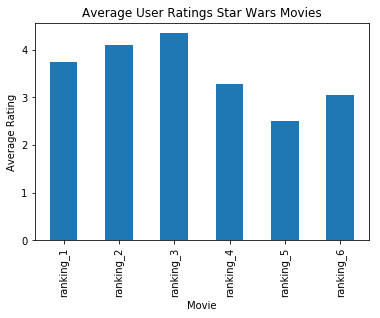

In [70]:
fig, ax = plt.subplots()
bar_positions = np.arange(6) + 1
tick_positions = range(1,7)
ax.set_xticks(tick_positions)
ax.set_xticklabels(ranking_means.index, rotation=90)
ax.set_xlabel('Movie')
ax.set_ylabel('Average Rating')
ax.set_title('Average User Ratings Star Wars Movies')

ax.bar(bar_positions, ranking_means.values, 0.5)



``Remember that a lower ranking is better!```
We can see that Star Wars The Empire Strikes Back is the mos popular one, what could be the reason behind this?

Earlier in this project, we cleaned up the seen columns and converted their values to the Boolean type. When we call methods like pandas.DataFrame.sum() or mean(), they treat Booleans like integers. They consider True a 1, and False a 0. That means we can figure out how many people have seen each movie just by taking the sum of the column


<Container object of 6 artists>

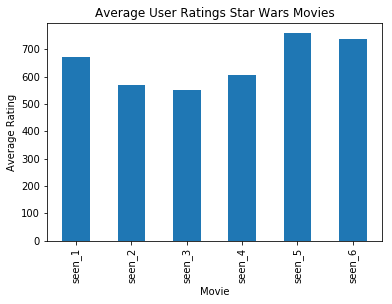

In [72]:
seen_movies = star_wars[star_wars.columns[3:9]].sum()


fig, ax = plt.subplots()
bar_positions = np.arange(6) + 1
tick_positions = range(1,7)
ax.set_xticks(tick_positions)
ax.set_xticklabels(seen_movies.index, rotation=90)
ax.set_xlabel('Movie')
ax.set_ylabel('Average Rating')
ax.set_title('Average User Ratings Star Wars Movies')

ax.bar(bar_positions, seen_movies.values, 0.5)


`````````````````````````````````````
So far, we can confirm that the original trilogy was seen by more people than the new one. This pretty much reinforces the fact that original trilogy was far more popular than the new one.

In [89]:
star_wars = star_wars.rename(columns={
    "Please state whether you view the following characters favorably, unfavorably, or are unfamiliar with him/her.": "Han Solo",
    "Unnamed: 16": "Luke Skywalker",
    "Unnamed: 17": "Princess Leia Organa",    
    "Unnamed: 18": "Anakin Skywalker",        
    "Unnamed: 19": "Obi Wan Kenobi",            
    "Unnamed: 20": "Emperor Palpatine",
    "Unnamed: 21": "Darth Vader",    
    "Unnamed: 22": "Lando Calrissian",        
    "Unnamed: 23": "Boba Fett",            
    "Unnamed: 24": "C-3P0",                
    "Unnamed: 25": "R2 D2",                    
    "Unnamed: 26": "Jar Jar Binks",                        
    "Unnamed: 27": "Padme Amidala",                            
    "Unnamed: 28": "Yoda"                                

})

In [106]:
star_wars['Yoda'].value_counts()

Very favorably                                 605
Somewhat favorably                             144
Neither favorably nor unfavorably (neutral)     51
Unfamiliar (N/A)                                10
Somewhat unfavorably                             8
Very unfavorably                                 8
Name: Yoda, dtype: int64

In [102]:
favorites = star_wars[star_wars.columns[15:29]] == 'Very favorably'
favorites = favorites.sum()
favorites

Han Solo                610
Luke Skywalker          552
Princess Leia Organa    547
Anakin Skywalker        245
Obi Wan Kenobi          591
Emperor Palpatine       110
Darth Vader             310
Lando Calrissian        142
Boba Fett               138
C-3P0                   474
R2 D2                   562
Jar Jar Binks           112
Padme Amidala           168
Yoda                    605
dtype: int64

<Container object of 14 artists>

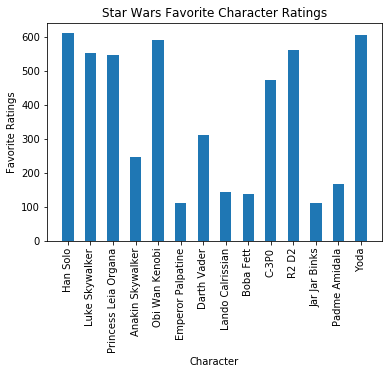

In [105]:
fig, ax = plt.subplots()
bar_positions = np.arange(14) + 1
tick_positions = range(1,15)
ax.set_xticks(tick_positions)
ax.set_xticklabels(favorites.index, rotation=90)
ax.set_xlabel('Character')
ax.set_ylabel('Favorite Ratings')
ax.set_title('Star Wars Favorite Character Ratings')

ax.bar(bar_positions, favorites.values, 0.5)


Kind of expected, the most loved characters are `Han Solo`, `Yoda` and `Obi Wan`. The original trilogy mostly focus on loved characters which clearly influences the movie ratings from the previous charts.

In [108]:
unliked = star_wars[star_wars.columns[15:29]] == 'Very unfavorably'
unliked = unliked.sum()
unliked

Han Solo                  1
Luke Skywalker            3
Princess Leia Organa      6
Anakin Skywalker         39
Obi Wan Kenobi            7
Emperor Palpatine       124
Darth Vader             149
Lando Calrissian          8
Boba Fett                45
C-3P0                     7
R2 D2                     6
Jar Jar Binks           204
Padme Amidala            34
Yoda                      8
dtype: int64

<Container object of 14 artists>

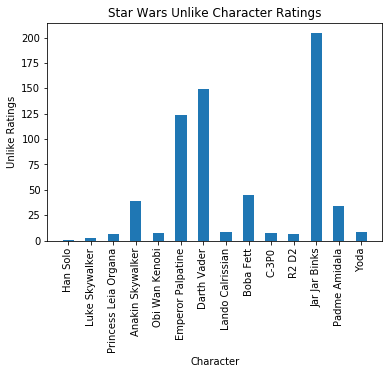

In [109]:
fig, ax = plt.subplots()
bar_positions = np.arange(14) + 1
tick_positions = range(1,15)
ax.set_xticks(tick_positions)
ax.set_xticklabels(unliked.index, rotation=90)
ax.set_xlabel('Character')
ax.set_ylabel('Unlike Ratings')
ax.set_title('Star Wars Unlike Character Ratings')

ax.bar(bar_positions, unliked.values, 0.5)


Daaaamn... `Jar Jar Binks` is most hated than the actual bad guy from the second trilogy (`Emperor Palpatine`). This is a very likely reason why people tend to like the original trilogy better than the new one.